# Santander Customer Transaction Prediction

In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve, confusion_matrix
from sklearn.externals import joblib
import matplotlib.pyplot as plt
import seaborn as sns


train_df = pd.read_csv("../project/data/train_small.csv", header=None)
test_df = pd.read_csv("../project/data/test_small.csv")

train_df.columns = list([test_df.columns[0],"target",*test_df.columns[1:]])

c:\users\moutz\desktop\pythonenv\venv\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Data Preprocessing

In [2]:
response = np.array(train_df['target'])
features = np.array(train_df.iloc[:,2:])
features_list = list(train_df.iloc[:,2:].columns)

from sklearn.model_selection import train_test_split
train_features, test_features, train_response, test_response = train_test_split(features, response, test_size = 0.25, random_state = 42)


In [3]:
print("train: ", 100*train_response.sum()/train_response.size,"   test: ", 100*test_response.sum()/test_response.size)

train:  10.009135548703894    test:  9.865829289180702


## Feature Selection 

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 100, random_state = 42, verbose = 10,n_jobs = -1)

rf.fit(train_features, train_response)



[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


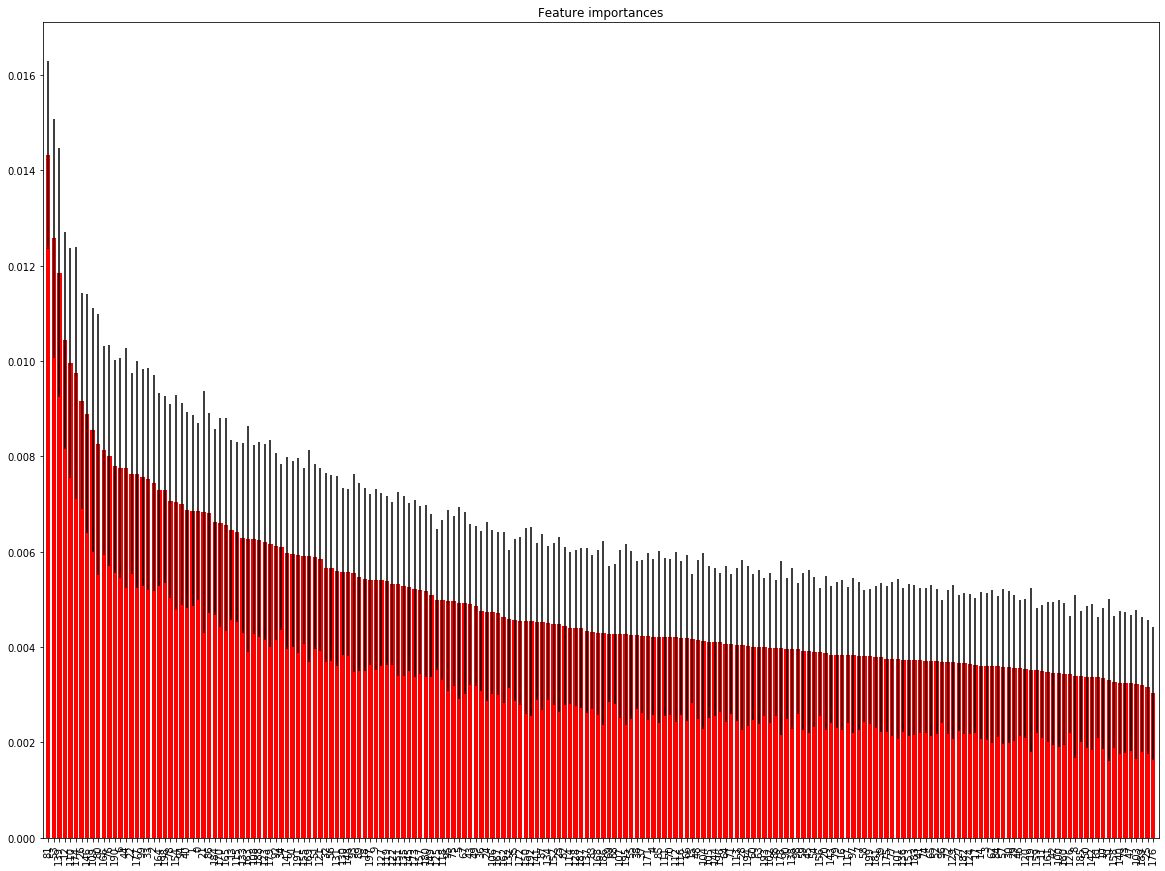

In [12]:
preds = rf.predict(test_features)
pd.crosstab(test_response, preds, rownames=['Actual Value'], colnames=['Predicted Value'])

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
# Plot the feature importances of the forest
plt.figure(figsize = (20,15))
plt.title("Feature importances")
plt.bar(range(test_features.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(test_features.shape[1]), indices, rotation='vertical')
plt.xlim([-1, test_features.shape[1]])
plt.show()

In [26]:
importances.min()

0.003029442174168279

In [39]:
def plt_density(df, var):
    plt.figure(figsize = (10,10))
    sns.distplot(train_df.loc[train_df['target'] == 0,var],hist = False, kde = True,
                     kde_kws = {'shade': True, 'linewidth': 3}, 
                      label = "target = 0")
    sns.distplot(train_df.loc[train_df['target'] == 1,var],hist = False, kde = True,
                     kde_kws = {'shade': True, 'linewidth': 3}, 
                      label = "target = 1")

    plt.title('Density Plot of ' + var)
    plt.xlabel(var)
    plt.ylabel('Density')
    plt.show()

# 3,4,7,10,11,14,15,16,17,19,20,23,25,27,29,30,31,32,37,38,39,41,42,45,46,47,50,52,54,55,57,59,60,61,63,64,65,68,69,72,73,77,79,82,83,84,85,89,90,96,97,98,100,101,102
# 103,104,105,,113,116,117,120,124,126,128,129

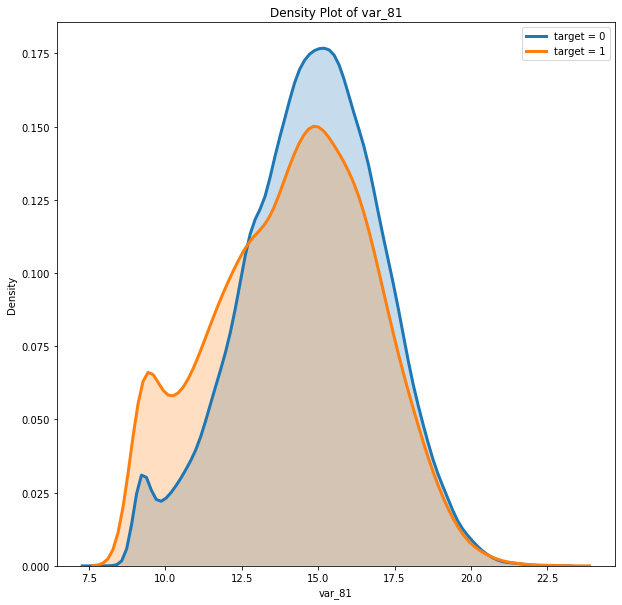

In [200]:
plt_density(train_df, 'var_81')

## Hyperparameter Tuning

In [58]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.sum(errors)/test_labels.size
    accuracy = 100 - mape
    fpr, tpr, thresholds = roc_curve(test_labels, predictions)
    plt.figure(figsize = (10,10))
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr, marker='.')
    plt.show()
    decision_boundary = 0.18
    predictions[predictions < decision_boundary] = 0
    predictions[predictions >= decision_boundary] = 1
    conf_mat = confusion_matrix(test_labels, predictions)
    print('Model Performance')
    print(conf_mat)
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

## Random search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# First create the base model to tune
rf = RandomForestRegressor(random_state = 42)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                              n_iter = 100, scoring='neg_mean_absolute_error', 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)

# Fit the random search model
rf_random.fit(train_features, train_response);

In [ ]:
rf_random.best_params_

In [ ]:
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(train_features, train_labels)
base_accuracy = evaluate(base_model, test_features, test_labels)

In [32]:
best_params_random = joblib.load("../project/best_params_rf.pkl")
best_estimator_random= joblib.load("../project/best_estimator_rf.pkl")
best_params_random

{'n_estimators': 2000,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 30,
 'bootstrap': False}

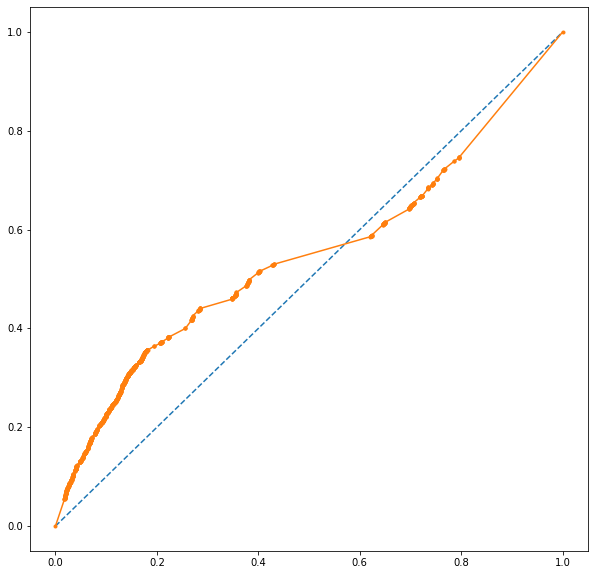

Model Performance
[[13793  1994]
 [ 1265   463]]
Accuracy = 83.76%.


In [59]:
random_accuracy = evaluate(best_estimator_random, test_features, test_response)

## Grid search 1

In [ ]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'max_depth': [20, 30, 40],
    'max_features': [2, 3],
    'min_samples_leaf': [4, 5, 6],
    'min_samples_split': [2, 3, 4],
    'n_estimators': [1800, 2000, 2200]
}

# Create a base model
rf = RandomForestRegressor(random_state = 42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, return_train_score=True)
grid_search.fit(train_features, train_labels)

In [ ]:
grid_search.best_params_

In [ ]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, test_features, test_labels)

### Grid search 2

In [ ]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [110, 120, None],
    'max_features': [3, 4],
    'min_samples_leaf': [5, 6, 7],
    'min_samples_split': [10],
    'n_estimators': [75, 100, 125]
}

# Create a base model
rf = RandomForestRegressor(random_state = 42)

# Instantiate the grid search model
grid_search_final = GridSearchCV(estimator = rf, param_grid = param_grid, 
                                 cv = 3, n_jobs = -1, verbose = 2, return_train_score=True)

grid_search_final.fit(train_features, train_labels);

In [ ]:
grid_search_final.best_params_

In [ ]:
best_grid_final = grid_search_final.best_estimator_
grid_final_accuracy = evaluate(best_grid_final, test_features, test_labels)

In [ ]:
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

# Logistic Regression

## Over Sampling

In [3]:
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0)
os_features,os_response=os.fit_sample(train_features, train_response)


Using TensorFlow backend.


In [4]:
print("length of oversampled data is ",len(os_features))
print("Number of 0 labels in oversampled data",len(os_response[os_response==0]))
print("Number of 1 labels",len(os_response[os_response==1]))
print("Proportion of 0 labels in oversampled data is ",len(os_response[os_response==0])/len(os_features))
print("Proportion of 1 labels in oversampled data is ",len(os_response[os_response==1])/len(os_features))

length of oversampled data is  94566
Number of 0 labels in oversampled data 47283
Number of 1 labels 47283
Proportion of 0 labels in oversampled data is  0.5
Proportion of 1 labels in oversampled data is  0.5


In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver='lbfgs',max_iter=1000)
rfe = RFECV(logreg, min_features_to_select  = 20, step=1, cv=5, n_jobs = -1, verbose = 10)
rfe = rfe.fit(os_features, os_response)

In [10]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='lbfgs',max_iter = 10000)
logreg.fit(os_features, os_response)

y_pred = logreg.predict(test_features)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(test_features, test_response)))


Accuracy of logistic regression classifier on test set: 0.79


## Model evaluation

In [18]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(test_response, y_pred)
print(conf_mat)

[[12475  3312]
 [  402  1326]]


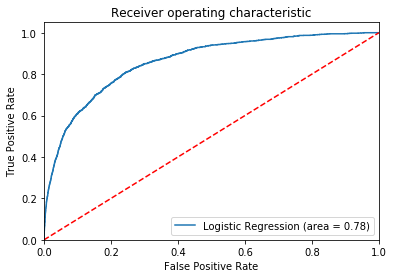

In [12]:
logit_roc_auc = roc_auc_score(test_response, logreg.predict(test_features))
fpr, tpr, thresholds = roc_curve(test_response, logreg.predict_proba(test_features)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [25]:
specificity = conf_mat[0,0]/(conf_mat[0,0] + conf_mat[0,1])
sensitivity = conf_mat[1,1]/(conf_mat[1,0] + conf_mat[1,1])
print("specificity=", specificity,"  sensitivity=",sensitivity)

specificity= 0.7902071324507506   sensitivity= 0.7673611111111112


## Neural Network

In [29]:
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.utils import to_categorical
import tensorflow as tf


def create_mlp():
    model = models.Sequential()
    model.add(layers.Dense(1028,activation = 'relu',input_dim=200))
    model.add(layers.Dense(512,activation = 'relu'))
    model.add(layers.Dense(256,activation = 'relu'))
    model.add(layers.Dense(128,activation = 'relu'))
    model.add(layers.Dense(2,activation = 'softmax'))
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return(model)

def create_callbacks(mod):
    filepath = "models/best-weights-mlp.hdf5"
    model_checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    return([model_checkpoint])

In [24]:
x_train = normalize(os_features, axis=0)

In [31]:
from sklearn.preprocessing import normalize
x_train = normalize(os_features, axis=0)
y_train = to_categorical(os_response, num_classes=2)
#y_train = train_response
x_test = normalize(test_features, axis=0)
y_test = to_categorical(test_response, num_classes=2)
#y_test = test_response
model = create_mlp()
callbacks_list = create_callbacks("mlp")
history = model.fit(x_train, 
                    y_train, 
                    epochs=20,
                    validation_data=(x_test,y_test),
                    callbacks = callbacks_list
                   )

Train on 94566 samples, validate on 17515 samples
Epoch 1/20
94368/94566 [============================>.] - ETA: 0s - loss: 0.5330 - accuracy: 0.7250
Epoch 00001: val_accuracy improved from -inf to 0.90711, saving model to models/best-weights-mlp.hdf5
94566/94566 [==============================] - 25s 263us/sample - loss: 0.5330 - accuracy: 0.7250 - val_loss: 0.3007 - val_accuracy: 0.9071
Epoch 2/20
94400/94566 [============================>.] - ETA: 0s - loss: 0.4848 - accuracy: 0.7646
Epoch 00002: val_accuracy improved from 0.90711 to 0.90722, saving model to models/best-weights-mlp.hdf5
94566/94566 [==============================] - 24s 257us/sample - loss: 0.4848 - accuracy: 0.7646 - val_loss: 0.5617 - val_accuracy: 0.9072
Epoch 3/20
94496/94566 [============================>.] - ETA: 0s - loss: 0.4437 - accuracy: 0.7931
Epoch 00003: val_accuracy did not improve from 0.90722
94566/94566 [==============================] - 25s 260us/sample - loss: 0.4436 - accuracy: 0.7932 - val_loss

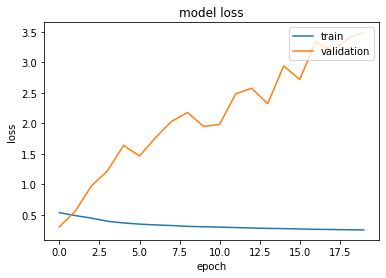

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Naive Bayes

In [46]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(train_features, train_response).predict(test_features)
print('Accuracy of naive bayes classifier on test set: {:.4f}'.format(gnb.score(test_features, test_response)))


Accuracy of naive bayes classifier on test set: 0.9226


In [45]:
y_pred.sum()/y_pred.size

0.05058521267485013

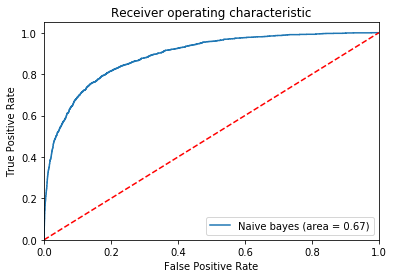

In [43]:
gnb_roc_auc = roc_auc_score(test_response, gnb.predict(test_features))
fpr, tpr, thresholds = roc_curve(test_response, gnb.predict_proba(test_features)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Naive bayes (area = %0.2f)' % gnb_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [47]:
conf_mat = confusion_matrix(test_response, y_pred)
print(conf_mat)

[[15530   257]
 [ 1099   629]]
